## Contemporary Music Recommendation System using Historical Preferences

### Overview

Many of us who are at the age when AARP cards arrive in the mail are still listening to the music of our highschool and college days. Exposure to new music has diminished due to the decreased use of the radio as part of our daily routines.  Spotify, iTunes, Pandora, and other music apps provide a plethora of music options, and they make recommendations for other music based on a playlist, but most often those recommendations are of the same time period and genre.  


#### Problem
Many of us would like to try new music, but don’t know where to start, and don’t have the patience or time to research or listen to new music as a hit or miss exercise.

#### Solution
My objective is to develop a recommendation system to highlight new songs and artists for listeners based on their  historical music preferences.

### References

I took inspiration, modeling tool suggestions, and, in some cases, actual code from the following sites.  These references are cited in the corresponding sections of this notebook. 

- **developer.spotify.com**
    - API endpoint and feature information
- **scikit-learn.org**
    - KMeans and Silhouette Score
    - Lasso regression
- **Towards Data Science**
    - Spotipy API extraction
    - K-Prototype Use Cases
- **pandas.pydata.org**
    - Changing series to an array
    - Referencing indeces
    - pd.get_dummies 

### Project Setup

#### Import Tools
In order to import, process, and build a model for song recommendations, I am importing the following tools, including those required for clustering and measuring the accuracy of recommendations: KMeans, KMode (for clustering categorical variables), PCA, Silhouette Score, and Cosine Distance 

In [944]:
import pandas as pd
import numpy as np
import io, sys, os, re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly.express as px
import requests
from itertools import chain
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.neighbors import KernelDensity
from scipy.spatial.distance import pdist

#### Import Data

This project includes obtaining the album and track audio features of songs from the 80s and 90s. These songs were found by identifying Spotify playlists representing music of different genres from this timeframe.  

##### Establish connection to Spotify's API

In [838]:
import http.client

con = http.client.HTTPConnection('https://api.spotify.com', 80, timeout=100)

print(con)

In [839]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util


In [840]:
# The following code passes credentials in order to access the Spotify API.  Credentials are stored 
# securely in a local file

with open("API.txt", encoding="utf-8-sig") as f:
    secret_ls = f.readlines()
    cid = secret_ls[0][:-1]
    secret = secret_ls[1]
        

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

#### Create Datasets 

 - **track_data** - A list is created (track_data) to store all of the album and audio features of each track in the .txt file
 - **data** - the data from track_data is appended to another list (data).  This allows for additional data to be appended to the file if more tracks are found for training the model without having to import the entire list which is time consuming  
 

##### Lists of track dictionaries

In [823]:
# Initialize datasets (lists)
# NOTE - If adding data, do not initialize the data list.  Comment this line out to keep existing data in tact

track_data = []
data = []

In [198]:
with open("URL.txt") as g:
    for url in g:
        playlist_link = url
        playlist_URI = playlist_link.split("/")[-1].split("?")[0]
        
        for track in sp.playlist_tracks(playlist_URI)["items"]:
            #URI
            track_uri = track["track"]["uri"]
    
            #Track name
            track_name = track["track"]["name"]
    
            #Main Artist
            artist_uri = track["track"]["artists"][0]["uri"]
            artist_info = sp.artist(artist_uri)
    
            #Name, popularity, genre (the first 6 genres in alphabetical order)
            artist_name = track["track"]["artists"][0]["name"]
            artist_pop = artist_info["popularity"]
            artist_genre_1 = artist_info["genres"][0:1]
            artist_genre_2 = artist_info["genres"][1:2]
            artist_genre_3 = artist_info["genres"][2:3]
            artist_genre_4 = artist_info["genres"][3:4]
            artist_genre_5 = artist_info["genres"][4:5]
            artist_genre_6 = artist_info["genres"][5:6]
    
            #Album
            album = track["track"]["album"]["name"]
            album_date = track["track"]["album"]["release_date"]
    
            #Popularity of the track
            track_pop = track["track"]["popularity"]
    
            #Track features
            danceability = sp.audio_features(track_uri)[0]['danceability']
            acousticness = sp.audio_features(track_uri)[0]['acousticness']
            energy = sp.audio_features(track_uri)[0]['energy']
            instrumentalness = sp.audio_features(track_uri)[0]['instrumentalness']
            key = sp.audio_features(track_uri)[0]['key']
            liveness = sp.audio_features(track_uri)[0]['liveness']
            loudness = sp.audio_features(track_uri)[0]['loudness']
            mode = sp.audio_features(track_uri)[0]['mode']
            speechiness = sp.audio_features(track_uri)[0]['speechiness']
            tempo = sp.audio_features(track_uri)[0]['tempo']
            valence = sp.audio_features(track_uri)[0]['valence']
    
            #List of Dictionary and audio feature items
            track_data = [
                track_uri, 
                track_name, 
                artist_name, 
                artist_pop, 
                artist_genre_1, 
                artist_genre_2, 
                artist_genre_3,
                artist_genre_4, 
                artist_genre_5, 
                artist_genre_6, 
                album, 
                album_date, 
                danceability, 
                acousticness, 
                energy, 
                instrumentalness, 
                key, 
                liveness, 
                loudness, 
                mode, 
                speechiness, 
                tempo, 
                valence]
    
            #Append track_data to data list
            data.append(track_data)

In [841]:
len(data)

0

##### Dataframes

In [655]:
# Convert dictionary (data) into pandas dataframe (df)
df = pd.DataFrame.from_dict(data)

##### Size and Shape of Dataframes

In [824]:
display(df.shape)
display(df.info)


(4227, 25)

<bound method DataFrame.info of                                  track_uri  \
0     spotify:track:1qPbGZqppFwLwcBC1JQ6Vr   
1     spotify:track:31AOj9sFz2gM0O3hMARRBx   
2     spotify:track:57iDDD9N9tTWe75x6qhStw   
3     spotify:track:1d6KS9GH06JAd19uiBy9IE   
4     spotify:track:5DiXcVovI0FcY2s0icWWUu   
...                                    ...   
5907  spotify:track:7mH6hpO4UguvZPbrZhrYwR   
5908  spotify:track:5eFCFpmDbqGqpdOVE9CXCh   
5909  spotify:track:5bGlU4BXhMRMMHWZnHuKhj   
5910  spotify:track:5OiphBsPdIMIldVkx5VXJb   
5911  spotify:track:25cVyUYzONCdHUeFWKbOol   

                                          track_name          artist_name  \
0                                         Wonderwall                Oasis   
1                                 Losing My Religion               R.E.M.   
2                              Bitter Sweet Symphony            The Verve   
3                             Ironic - 2015 Remaster    Alanis Morissette   
4                             

In [657]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5912 entries, 0 to 5911
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       5912 non-null   object 
 1   1       5912 non-null   object 
 2   2       5912 non-null   object 
 3   3       5912 non-null   int64  
 4   4       5912 non-null   object 
 5   5       5912 non-null   object 
 6   6       5912 non-null   object 
 7   7       5912 non-null   object 
 8   8       5912 non-null   object 
 9   9       5912 non-null   object 
 10  10      5912 non-null   object 
 11  11      5912 non-null   object 
 12  12      5912 non-null   float64
 13  13      5912 non-null   float64
 14  14      5912 non-null   float64
 15  15      5912 non-null   float64
 16  16      5912 non-null   int64  
 17  17      5912 non-null   float64
 18  18      5912 non-null   float64
 19  19      5912 non-null   int64  
 20  20      5912 non-null   float64
 21  21      5912 non-null   float64
 22  

In [658]:
# Update column headers

df.columns = ['track_uri', 
        'track_name', 
        'artist_name', 
        'artist_pop', 
        'artist_genre_1', 
        'artist_genre_2', 
        'artist_genre_3',
        'artist_genre_4', 
        'artist_genre_5', 
        'artist_genre_6', 
        'album', 
        'album_date', 
        'danceability', 
        'acousticness', 
        'energy', 
        'instrumentalness', 
        'key', 
        'liveness', 
        'loudness', 
        'mode', 
        'speechiness', 
        'tempo', 
        'valence']

##### Remove duplicate tracks from dataframe

Audio tracks may be duplicated across playlists.  As a result, the code below will identify duplicate entries and subsequently drop them from the file

In [659]:
df.drop_duplicates(subset = ['track_uri'], inplace = True)

In [660]:
type(df)

pandas.core.frame.DataFrame

In [661]:
# Convert album date to a date format
df['album_date'] = pd.to_datetime(df['album_date'])

In [662]:
df['album_date']

0      1995-10-02
1      1991-03-12
2      1997-09-29
3      1995-01-01
4      1993-01-01
          ...    
5907   2015-03-20
5908   1989-01-01
5909   1989-11-14
5910   2013-03-17
5911   1988-01-01
Name: album_date, Length: 4227, dtype: datetime64[ns]

In [663]:
df

,track_uri,track_name,artist_name,artist_pop,artist_genre_1,artist_genre_2,artist_genre_3,artist_genre_4,artist_genre_5,artist_genre_6,...,acousticness,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
0,spotify:track:1qPbGZqppFwLwcBC1JQ6Vr,Wonderwall,Oasis,75,beatlesque,britpop,[madchester],[permanent wave],[rock],[],...,0.002360,0.854,0.000000,2,0.1330,-5.609,1,0.0366,174.584,0.456
1,spotify:track:31AOj9sFz2gM0O3hMARRBx,Losing My Religion,R.E.M.,72,alternative rock,athens indie,[permanent wave],[pop rock],[rock],[],...,0.179000,0.855,0.000001,9,0.0987,-5.051,0,0.0295,125.639,0.803
2,spotify:track:57iDDD9N9tTWe75x6qhStw,Bitter Sweet Symphony,The Verve,65,alternative rock,britpop,[permanent wave],[pop rock],[rock],[shoegaze],...,0.033500,0.917,0.000000,9,0.4060,-6.006,1,0.0479,171.176,0.518
3,spotify:track:1d6KS9GH06JAd19uiBy9IE,Ironic - 2015 Remaster,Alanis Morissette,67,canadian pop,canadian singer-songwriter,[pop rock],[singer-songwriter],[],[],...,0.218000,0.582,0.000000,11,0.1590,-8.305,1,0.0508,114.926,0.365
4,spotify:track:5DiXcVovI0FcY2s0icWWUu,Mr. Jones,Counting Crows,67,alternative rock,neo mellow,[pop rock],[rock],[],[],...,0.183000,0.817,0.000003,0,0.2850,-6.542,1,0.0363,141.621,0.726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5907,spotify:track:7mH6hpO4UguvZPbrZhrYwR,Work It to the Bone,LNR,15,[],[],[],[],[],[],...,0.001200,0.838,0.105000,1,0.0430,-6.011,1,0.0588,122.833,0.495
5908,spotify:track:5eFCFpmDbqGqpdOVE9CXCh,That's the Way Love Is - Underground Mix; Edit,Ten City,34,[chicago house],[classic house],[deep house],[hip house],[vocal house],[],...,0.011100,0.742,0.000095,7,0.0762,-11.421,1,0.0485,120.772,0.698
5909,spotify:track:5bGlU4BXhMRMMHWZnHuKhj,Someday,CeCe Rogers,39,[classic house],[],[],[],[],[],...,0.032500,0.538,0.000240,9,0.0415,-15.149,0,0.0520,119.582,0.844
5910,spotify:track:5OiphBsPdIMIldVkx5VXJb,You’re Gonna Miss Me - 1988 Mix,Turntable Orchestra,5,[garage house],[],[],[],[],[],...,0.057300,0.776,0.344000,1,0.2190,-7.462,0,0.0587,115.812,0.781


In [709]:
#  Convert list columns to string

df['artist_genre_1'] = df.artist_genre_1.apply(''.join)
df['artist_genre_2'] = df.artist_genre_2.apply(''.join)
df['artist_genre_3'] = df.artist_genre_3.apply(''.join)
df['artist_genre_4'] = df.artist_genre_4.apply(''.join)
df['artist_genre_5'] = df.artist_genre_5.apply(''.join)
df['artist_genre_6'] = df.artist_genre_6.apply(''.join)

In [710]:
df

,track_uri,track_name,artist_name,artist_pop,artist_genre_1,artist_genre_2,artist_genre_3,artist_genre_4,artist_genre_5,artist_genre_6,...,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,cluster_label
0,spotify:track:1qPbGZqppFwLwcBC1JQ6Vr,Wonderwall,Oasis,75,beatlesque,britpop,madchester,permanent wave,rock,,...,0.854,0.000000,2,0.1330,-5.609,1,0.0366,174.584,0.456,1
1,spotify:track:31AOj9sFz2gM0O3hMARRBx,Losing My Religion,R.E.M.,72,alternative rock,athens indie,permanent wave,pop rock,rock,,...,0.855,0.000001,9,0.0987,-5.051,0,0.0295,125.639,0.803,0
2,spotify:track:57iDDD9N9tTWe75x6qhStw,Bitter Sweet Symphony,The Verve,65,alternative rock,britpop,permanent wave,pop rock,rock,shoegaze,...,0.917,0.000000,9,0.4060,-6.006,1,0.0479,171.176,0.518,1
3,spotify:track:1d6KS9GH06JAd19uiBy9IE,Ironic - 2015 Remaster,Alanis Morissette,67,canadian pop,canadian singer-songwriter,pop rock,singer-songwriter,,,...,0.582,0.000000,11,0.1590,-8.305,1,0.0508,114.926,0.365,2
4,spotify:track:5DiXcVovI0FcY2s0icWWUu,Mr. Jones,Counting Crows,67,alternative rock,neo mellow,pop rock,rock,,,...,0.817,0.000003,0,0.2850,-6.542,1,0.0363,141.621,0.726,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5907,spotify:track:7mH6hpO4UguvZPbrZhrYwR,Work It to the Bone,LNR,15,,,,,,,...,0.838,0.105000,1,0.0430,-6.011,1,0.0588,122.833,0.495,0
5908,spotify:track:5eFCFpmDbqGqpdOVE9CXCh,That's the Way Love Is - Underground Mix; Edit,Ten City,34,chicago house,classic house,deep house,hip house,vocal house,,...,0.742,0.000095,7,0.0762,-11.421,1,0.0485,120.772,0.698,0
5909,spotify:track:5bGlU4BXhMRMMHWZnHuKhj,Someday,CeCe Rogers,39,classic house,,,,,,...,0.538,0.000240,9,0.0415,-15.149,0,0.0520,119.582,0.844,0
5910,spotify:track:5OiphBsPdIMIldVkx5VXJb,You’re Gonna Miss Me - 1988 Mix,Turntable Orchestra,5,garage house,,,,,,...,0.776,0.344000,1,0.2190,-7.462,0,0.0587,115.812,0.781,3


In [701]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4227 entries, 0 to 5911
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   track_uri         4227 non-null   object        
 1   track_name        4227 non-null   object        
 2   artist_name       4227 non-null   object        
 3   artist_pop        4227 non-null   int64         
 4   artist_genre_1    4227 non-null   object        
 5   artist_genre_2    4227 non-null   object        
 6   artist_genre_3    4227 non-null   object        
 7   artist_genre_4    4227 non-null   object        
 8   artist_genre_5    4227 non-null   object        
 9   artist_genre_6    4227 non-null   object        
 10  album             4227 non-null   object        
 11  album_date        4227 non-null   datetime64[ns]
 12  danceability      4227 non-null   float64       
 13  acousticness      4227 non-null   float64       
 14  energy            4227 n

In [855]:
## Temp

import csv

df.to_csv('df.csv', index = True)

df = pd.read_csv('df.csv')

In [856]:
df.describe()

,Unnamed: 0.1,Unnamed: 0,artist_pop,album_date,danceability,acousticness,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
count,4227.000000,4227.000000,4227.000000,4.227000e+03,4227.000000,4227.000000,4227.000000,4227.000000,4227.000000,4227.000000,4227.000000,4227.000000,4227.000000,4227.000000,4227.000000
mean,2113.000000,2959.037142,56.615803,8.004467e+17,0.634548,0.152036,0.709735,0.070586,5.395079,0.183009,-8.391132,0.658150,0.075470,121.129114,0.626896
std,1220.374123,1768.828193,15.971224,3.439361e+17,0.164875,0.202148,0.196420,0.195552,3.620883,0.151657,3.400342,0.474386,0.078587,25.940937,0.239351
min,0.000000,0.000000,0.000000,-4.051296e+17,0.062100,0.000001,0.017400,0.000000,0.000000,0.011600,-27.547000,0.000000,0.022400,58.396000,0.032600
25%,1056.500000,1446.000000,48.000000,5.417280e+17,0.534000,0.009785,0.577500,0.000000,2.000000,0.081500,-10.501000,0.000000,0.033900,102.313000,0.453000
50%,2113.000000,2936.000000,59.000000,7.790688e+17,0.654000,0.064500,0.739000,0.000109,6.000000,0.126000,-7.786000,1.000000,0.044900,119.872000,0.665000
75%,3169.500000,4562.500000,68.000000,9.783072e+17,0.752000,0.214000,0.870000,0.009610,9.000000,0.250500,-5.896500,1.000000,0.075900,133.972500,0.825500
max,4226.000000,5911.000000,89.000000,1.660867e+18,0.988000,0.991000,0.999000,0.987000,11.000000,0.986000,-0.140000,1.000000,0.944000,208.571000,0.982000


array([[<AxesSubplot:title={'center':'Unnamed: 0'}>,
        <AxesSubplot:title={'center':'artist_pop'}>,
        <AxesSubplot:title={'center':'album_date'}>,
        <AxesSubplot:title={'center':'danceability'}>],
       [<AxesSubplot:title={'center':'acousticness'}>,
        <AxesSubplot:title={'center':'energy'}>,
        <AxesSubplot:title={'center':'instrumentalness'}>,
        <AxesSubplot:title={'center':'key'}>],
       [<AxesSubplot:title={'center':'liveness'}>,
        <AxesSubplot:title={'center':'loudness'}>,
        <AxesSubplot:title={'center':'mode'}>,
        <AxesSubplot:title={'center':'speechiness'}>],
       [<AxesSubplot:title={'center':'tempo'}>,
        <AxesSubplot:title={'center':'valence'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

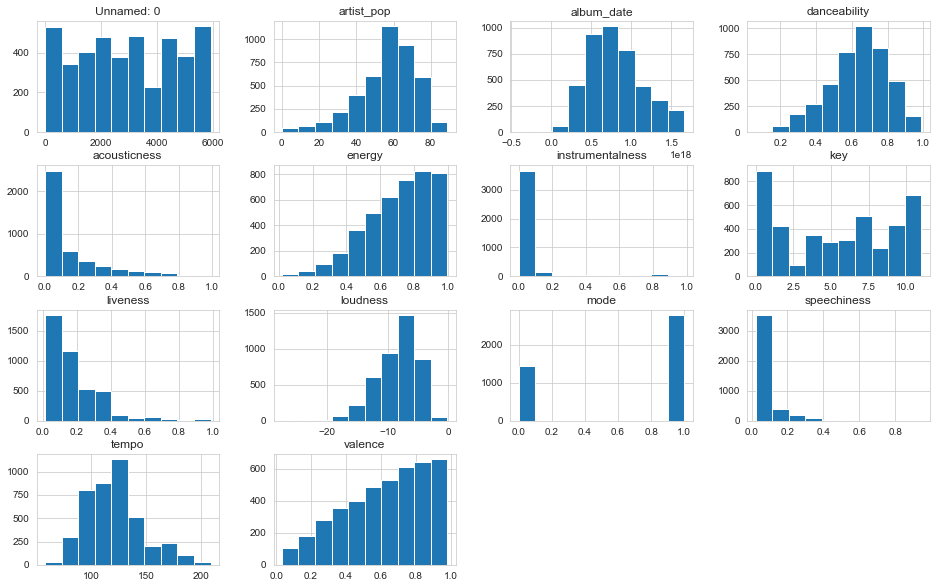

In [847]:
df.hist(figsize = (16,10))

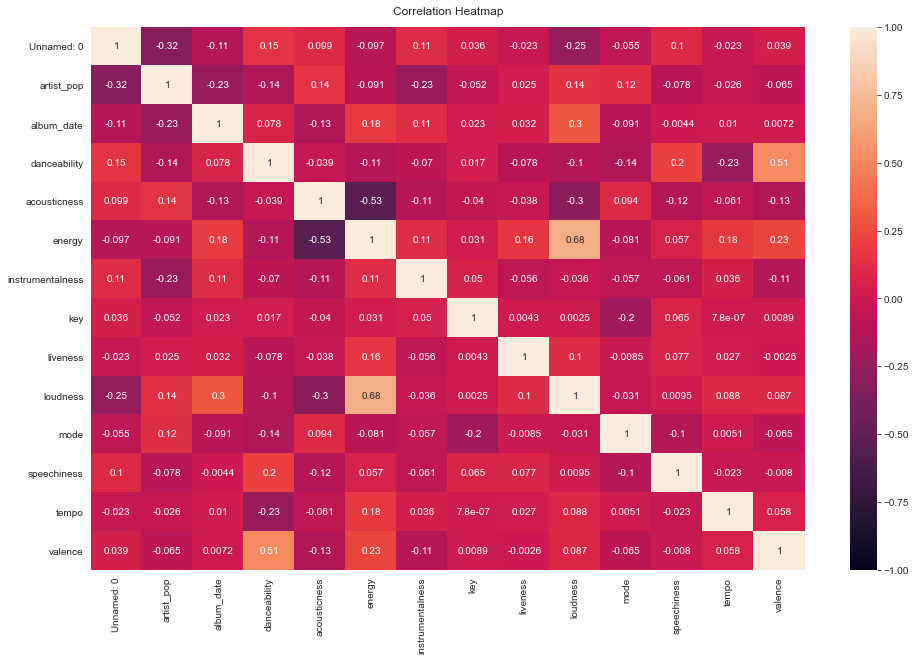

In [851]:
plt.figure(figsize = (16,10))

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.

heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);


### Clustering

#### Create clusters using KMeans

In [911]:

#RENAME DF FILE BACK TO DF_IMPORT!#

cluster_pipeline = Pipeline([('scaler', StandardScaler()), 
                             ('kmeans', KMeans(n_clusters=4, n_init=10,
                             verbose=2))], verbose=True)

X = df_import.select_dtypes(np.number)
number_cols = list(X.columns)
cluster_pipeline.fit(X)

cluster_labels = cluster_pipeline.predict(X)
df_import['cluster_label'] = cluster_labels


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
Initialization complete
Iteration 0, inertia 71088.63122110465
Iteration 1, inertia 54861.58166548236
Iteration 2, inertia 52527.185034049806
Iteration 3, inertia 51035.046614016814
Iteration 4, inertia 50006.53400311079
Iteration 5, inertia 49470.655737257744
Iteration 6, inertia 48956.2936693907
Iteration 7, inertia 48244.24632098934
Iteration 8, inertia 47739.79086507783
Iteration 9, inertia 47737.57596012421
Converged at iteration 9: strict convergence.
Initialization complete
Iteration 0, inertia 71735.9123148013
Iteration 1, inertia 53523.90441805981
Iteration 2, inertia 51534.82272569196
Iteration 3, inertia 50681.795308564084
Iteration 4, inertia 50132.82486502952
Iteration 5, inertia 49479.49195311744
Iteration 6, inertia 48622.152408706366
Iteration 7, inertia 47878.79160798908
Iteration 8, inertia 47744.700449419586
Iteration 9, inertia 47737.57596012421
Converged at iteration 9: strict convergence.
Initi

Create Clusters by Track using KMeans

In [912]:
#RENAME DF FILE BACK TO DF_IMPORT!#
# setting verbose = 2 to display and plot inertia values

X = df_import.select_dtypes(np.number)

scaler = StandardScaler()
scaler.fit(X)
kmeans = KMeans(n_clusters=4, verbose=2, n_init=10) #<-- init=1, verbose=2
kmeans.fit(X)
print(scaler.mean_)


cluster_label = kmeans.predict(X)
df_import[cluster_label] = cluster_label



Initialization complete
Iteration 0, inertia 6.638595150790696e+37
Iteration 1, inertia 5.800450362640922e+37
Iteration 2, inertia 5.764366245358155e+37
Iteration 3, inertia 5.75919103424994e+37
Iteration 4, inertia 5.758561516745999e+37
Iteration 5, inertia 5.758494688630951e+37
Converged at iteration 5: center shift 1.4674972783182338e+29 within tolerance 5.913203116245516e+29.
Initialization complete
Iteration 0, inertia 5.468402113542143e+37
Iteration 1, inertia 5.264815804838282e+37
Iteration 2, inertia 5.23545393663108e+37
Iteration 3, inertia 5.220804051795049e+37
Iteration 4, inertia 5.218729343375914e+37
Iteration 5, inertia 5.2185694306230485e+37
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 5.872214184431575e+37
Iteration 1, inertia 5.5494946604723e+37
Iteration 2, inertia 5.536872001088638e+37
Iteration 3, inertia 5.534980892652975e+37
Iteration 4, inertia 5.519329588678055e+37
Iteration 5, inertia 5.517189636262512e+37
Iteration

In [913]:
#RENAME DF FILE BACK TO DF_IMPORT!#
df_import['cluster_label'].value_counts()

3    1866
0    1415
1     642
2     304
Name: cluster_label, dtype: int64

In [916]:
#RENAME DF FILE BACK TO DF_IMPORT!#
df_import = df_import.fillna("X")
df_import

,Unnamed: 0.1,Unnamed: 0,track_uri,track_name,artist_name,artist_pop,artist_genre_1,artist_genre_2,artist_genre_3,artist_genre_4,...,loudness,mode,speechiness,tempo,valence,0,3,1,2,cluster_label
0,0,0,spotify:track:1qPbGZqppFwLwcBC1JQ6Vr,Wonderwall,Oasis,75,beatlesque,britpop,madchester,permanent wave,...,-5.609,1,0.0366,174.584,0.456,0,3,1,2,3
1,1,1,spotify:track:31AOj9sFz2gM0O3hMARRBx,Losing My Religion,R.E.M.,72,alternative rock,athens indie,permanent wave,pop rock,...,-5.051,0,0.0295,125.639,0.803,0,3,1,2,3
2,2,2,spotify:track:57iDDD9N9tTWe75x6qhStw,Bitter Sweet Symphony,The Verve,65,alternative rock,britpop,permanent wave,pop rock,...,-6.006,1,0.0479,171.176,0.518,0,3,1,2,3
3,3,3,spotify:track:1d6KS9GH06JAd19uiBy9IE,Ironic - 2015 Remaster,Alanis Morissette,67,canadian pop,canadian singer-songwriter,pop rock,singer-songwriter,...,-8.305,1,0.0508,114.926,0.365,0,3,1,2,3
4,4,4,spotify:track:5DiXcVovI0FcY2s0icWWUu,Mr. Jones,Counting Crows,67,alternative rock,neo mellow,pop rock,rock,...,-6.542,1,0.0363,141.621,0.726,0,3,1,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4222,4222,5907,spotify:track:7mH6hpO4UguvZPbrZhrYwR,Work It to the Bone,LNR,15,X,X,X,X,...,-6.011,1,0.0588,122.833,0.495,0,3,1,2,0
4223,4223,5908,spotify:track:5eFCFpmDbqGqpdOVE9CXCh,That's the Way Love Is - Underground Mix; Edit,Ten City,34,chicago house,classic house,deep house,hip house,...,-11.421,1,0.0485,120.772,0.698,0,3,1,2,0
4224,4224,5909,spotify:track:5bGlU4BXhMRMMHWZnHuKhj,Someday,CeCe Rogers,39,classic house,X,X,X,...,-15.149,0,0.0520,119.582,0.844,0,3,1,2,0
4225,4225,5910,spotify:track:5OiphBsPdIMIldVkx5VXJb,You’re Gonna Miss Me - 1988 Mix,Turntable Orchestra,5,garage house,X,X,X,...,-7.462,0,0.0587,115.812,0.781,0,3,1,2,0


##### Plot inertia to identify optimal number of clusters

Text(0.5, 1.0, 'Different Inertia Values for Different Number of Clusters')

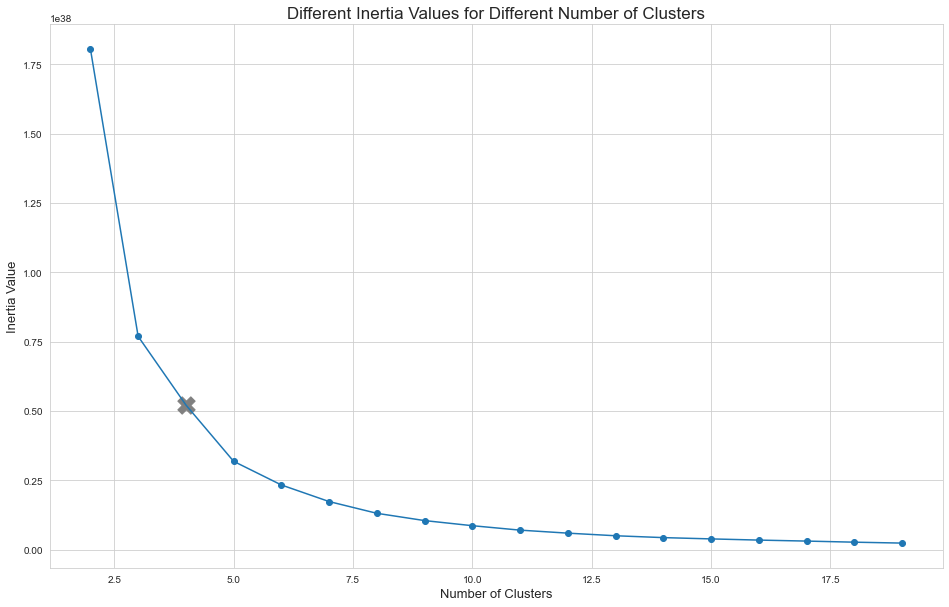

In [917]:
# Plotting Inertia

%matplotlib inline

## Reference plotting inertia article
plt.rcParams['figure.figsize'] = [16,10]
sns.set_style("whitegrid")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

inertia_list = []
for n in range(2, 20):
    kmeans_model = KMeans(n_clusters=n)
    kmeans_model.fit(X)
    inertia_list.append(kmeans_model.inertia_)
    
# plot the inertia curve
plt.plot(range(2,20),inertia_list)
plt.scatter(range(2,20),inertia_list)
plt.scatter(4, inertia_list[2], marker="X", s=300, c="gray")
plt.xlabel("Number of Clusters", size=13)
plt.ylabel("Inertia Value", size=13)
plt.title("Different Inertia Values for Different Number of Clusters", size=17)

In [897]:
number_cols

['Unnamed: 0.1',
 'Unnamed: 0',
 'artist_pop',
 'album_date',
 'danceability',
 'acousticness',
 'energy',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'speechiness',
 'tempo',
 'valence',
 0,
 3,
 1,
 2]

In [898]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4227 entries, 0 to 4226
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0.1      4227 non-null   int64  
 1   Unnamed: 0        4227 non-null   int64  
 2   artist_pop        4227 non-null   int64  
 3   album_date        4227 non-null   int64  
 4   danceability      4227 non-null   float64
 5   acousticness      4227 non-null   float64
 6   energy            4227 non-null   float64
 7   instrumentalness  4227 non-null   float64
 8   key               4227 non-null   int64  
 9   liveness          4227 non-null   float64
 10  loudness          4227 non-null   float64
 11  mode              4227 non-null   int64  
 12  speechiness       4227 non-null   float64
 13  tempo             4227 non-null   float64
 14  valence           4227 non-null   float64
 15  0                 4227 non-null   int32  
 16  3                 4227 non-null   int32  


In [899]:
type(X['key'])
X

,Unnamed: 0.1,Unnamed: 0,artist_pop,album_date,danceability,acousticness,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,0,3,1,2,cluster_label
0,0,0,75,812592000000000000,0.410,0.002360,0.854,0.000000,2,0.1330,-5.609,1,0.0366,174.584,0.456,0,3,1,2,2
1,1,1,72,668736000000000000,0.666,0.179000,0.855,0.000001,9,0.0987,-5.051,0,0.0295,125.639,0.803,0,3,1,2,2
2,2,2,65,875491200000000000,0.356,0.033500,0.917,0.000000,9,0.4060,-6.006,1,0.0479,171.176,0.518,0,3,1,2,2
3,3,3,67,788918400000000000,0.408,0.218000,0.582,0.000000,11,0.1590,-8.305,1,0.0508,114.926,0.365,0,3,1,2,2
4,4,4,67,725846400000000000,0.578,0.183000,0.817,0.000003,0,0.2850,-6.542,1,0.0363,141.621,0.726,0,3,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4222,4222,5907,15,1426809600000000000,0.819,0.001200,0.838,0.105000,1,0.0430,-6.011,1,0.0588,122.833,0.495,0,3,1,2,3
4223,4223,5908,34,599616000000000000,0.638,0.011100,0.742,0.000095,7,0.0762,-11.421,1,0.0485,120.772,0.698,0,3,1,2,3
4224,4224,5909,39,627004800000000000,0.704,0.032500,0.538,0.000240,9,0.0415,-15.149,0,0.0520,119.582,0.844,0,3,1,2,3
4225,4225,5910,5,1363478400000000000,0.742,0.057300,0.776,0.344000,1,0.2190,-7.462,0,0.0587,115.812,0.781,0,3,1,2,3


##### Visualizing the clusters

<AxesSubplot:>

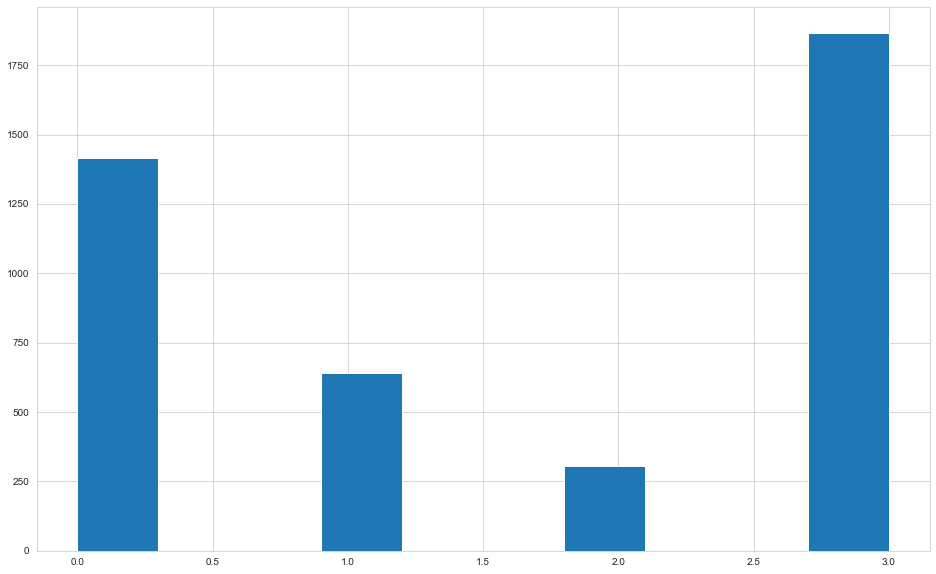

In [918]:
#RENAME DF FILE BACK TO DF_IMPORT!#

df_import['cluster_label'].hist()

In [919]:
df_import['cluster_label'].value_counts(normalize=True)


3    0.441448
0    0.334753
1    0.151881
2    0.071919
Name: cluster_label, dtype: float64

##### Run PCA

In [974]:
from sklearn.decomposition import PCA
pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding = pca_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=song_embedding)

projection['cluster'] = X['cluster_label']

Xpca = projection
Xpca


,x,y,cluster
0,-0.257548,-3.572641,1
1,-0.742773,-0.378995,1
2,-0.664657,-2.630761,1
3,1.740394,-1.538640,1
4,-0.018185,-1.304623,1
...,...,...,...
4222,-0.931089,0.008217,2
4223,-0.687947,0.232501,2
4224,-0.422733,2.001829,2
4225,-1.910740,0.656041,2


###### Plot Clusters After PCA

##### Calculate Silhouette Scores

For n_clusters = 2 The average silhouette_score is : 0.4227128364407175
For n_clusters = 3 The average silhouette_score is : 0.3806388689923808
For n_clusters = 4 The average silhouette_score is : 0.3245379734057975
For n_clusters = 5 The average silhouette_score is : 0.34418264063922144
For n_clusters = 6 The average silhouette_score is : 0.3162309259968848


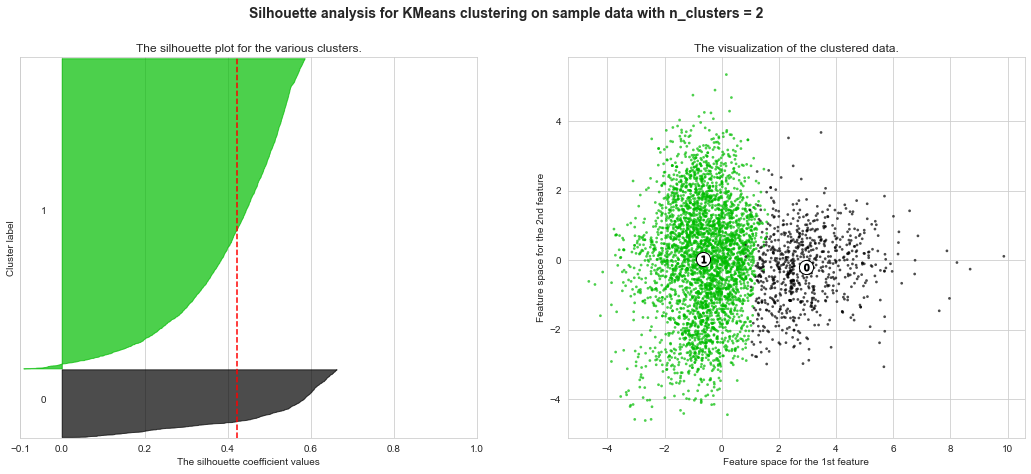

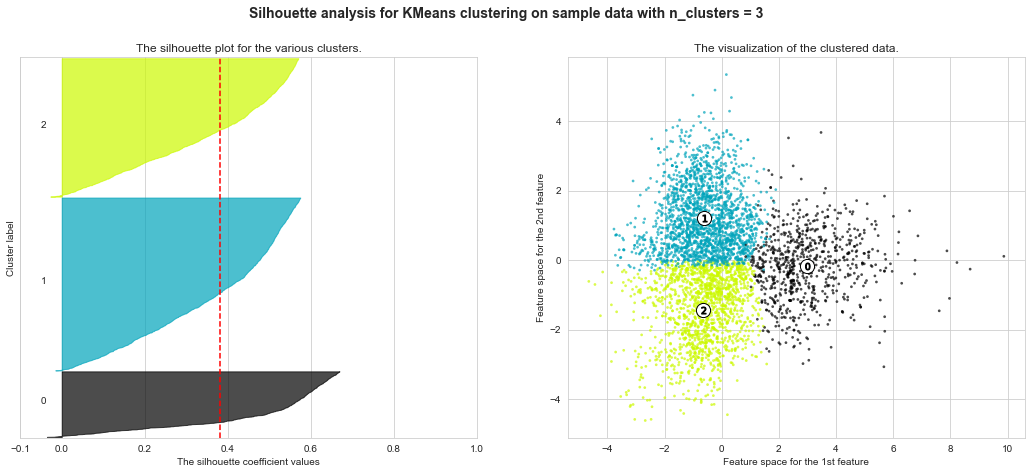

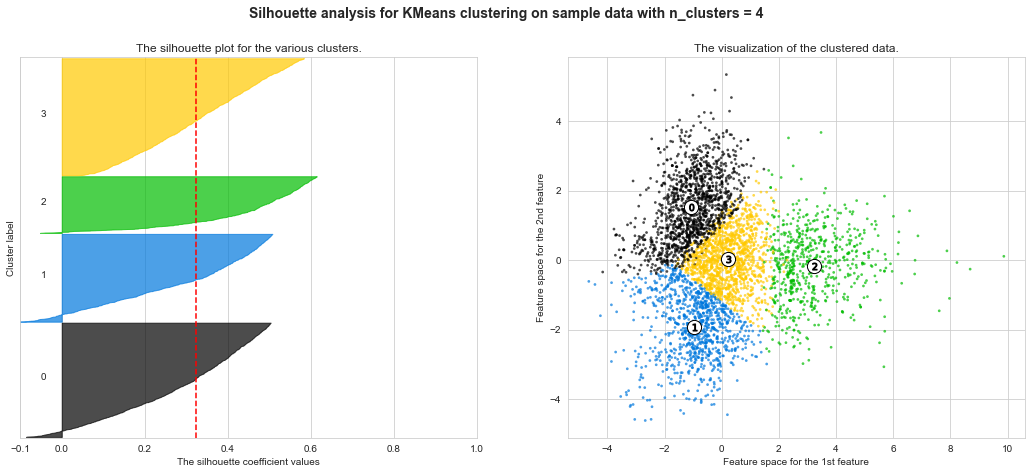

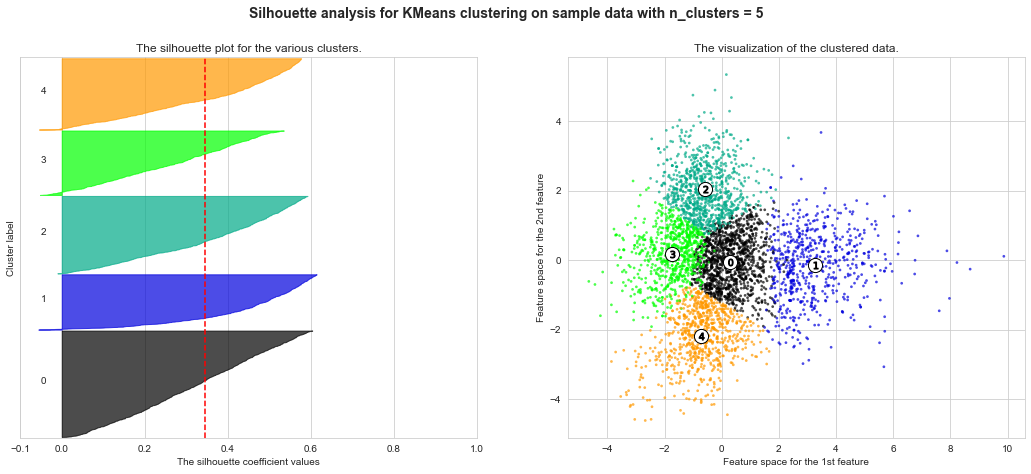

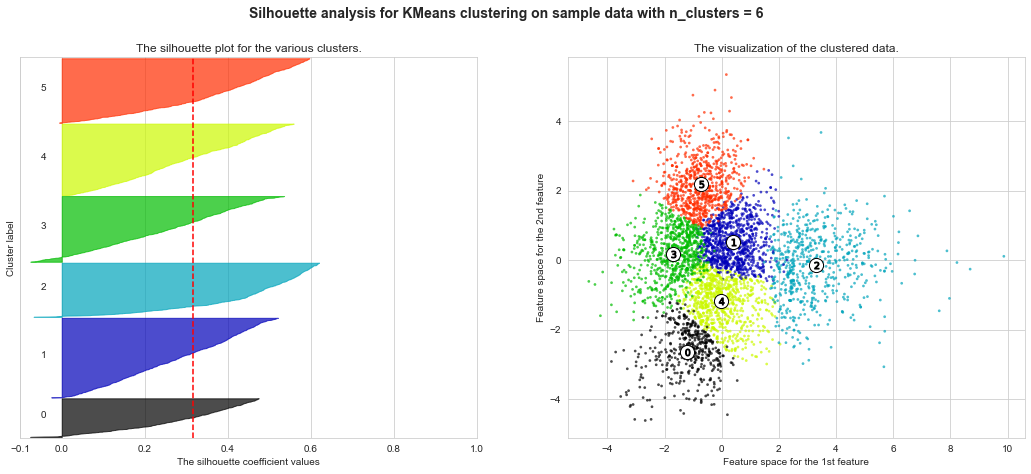

In [978]:
range_n_clusters = [2, 3, 4, 5, 6]

%matplotlib inline
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(Xpca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(Xpca)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(Xpca, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(Xpca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        Xpca.iloc[:, 0], Xpca.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

For n_clusters = 2 The average silhouette_score is : 0.38893097689581735


ValueError: x and y must be the same size

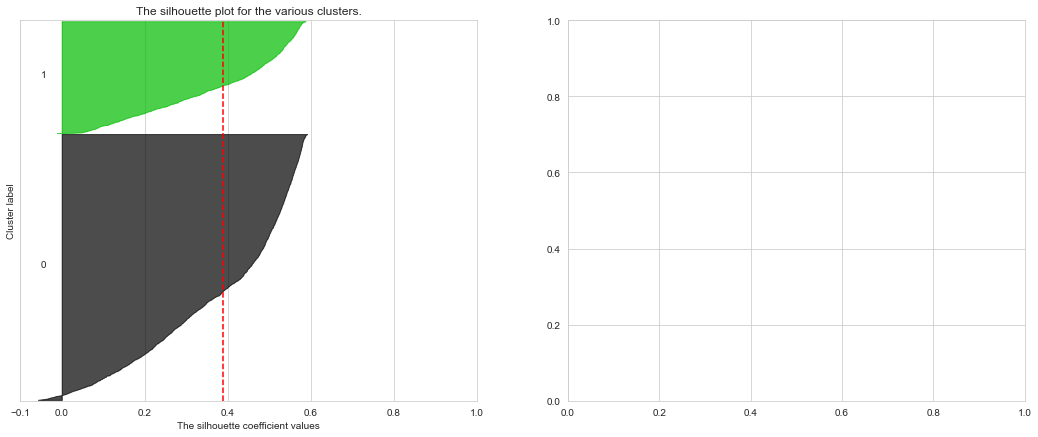

In [719]:
#Calculate Silhoutte score using Silhouette Samples

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:0], X[:1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )
    
    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

#### Create K-Prototype Clusters using K-Means and K-Mode

In order to use both categorical and continuous variables to create clusters, I am using the K-Mode clustering algorithm in addition to KMeans with K-Prototype

https://towardsdatascience.com/clustering-algorithm-for-data-with-mixed-categorical-and-numerical-features-d4e3a48066a0

***Prepare the data for K-Prototype:***

    - Scale values in dataframe
    - Convert dataframe to array
    - Make numeric variables float
    - Create a list containing the index of the categorical variables

In [920]:
#RENAME DF FILE BACK TO DF_IMPORT!#

#Scale values

X_num = df_import.select_dtypes(np.number)

scaler = StandardScaler()
scaler.fit(X_num)



StandardScaler()

In [921]:
#Concatenate scaled numeric and categorical values and convert new dataframe to array

X_num_cat = (df_import[['artist_genre_1', 'artist_genre_2', 'artist_genre_3', \
       'artist_genre_4', 'artist_genre_5', 'artist_genre_6']], X_num)
XKP = pd.concat(X_num_cat, axis=1)

XKP_array = XKP.values
XKP


,artist_genre_1,artist_genre_2,artist_genre_3,artist_genre_4,artist_genre_5,artist_genre_6,Unnamed: 0.1,Unnamed: 0,artist_pop,album_date,...,loudness,mode,speechiness,tempo,valence,0,3,1,2,cluster_label
0,beatlesque,britpop,madchester,permanent wave,rock,X,0,0,75,812592000000000000,...,-5.609,1,0.0366,174.584,0.456,0,3,1,2,3
1,alternative rock,athens indie,permanent wave,pop rock,rock,X,1,1,72,668736000000000000,...,-5.051,0,0.0295,125.639,0.803,0,3,1,2,3
2,alternative rock,britpop,permanent wave,pop rock,rock,shoegaze,2,2,65,875491200000000000,...,-6.006,1,0.0479,171.176,0.518,0,3,1,2,3
3,canadian pop,canadian singer-songwriter,pop rock,singer-songwriter,X,X,3,3,67,788918400000000000,...,-8.305,1,0.0508,114.926,0.365,0,3,1,2,3
4,alternative rock,neo mellow,pop rock,rock,X,X,4,4,67,725846400000000000,...,-6.542,1,0.0363,141.621,0.726,0,3,1,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4222,X,X,X,X,X,X,4222,5907,15,1426809600000000000,...,-6.011,1,0.0588,122.833,0.495,0,3,1,2,0
4223,chicago house,classic house,deep house,hip house,vocal house,X,4223,5908,34,599616000000000000,...,-11.421,1,0.0485,120.772,0.698,0,3,1,2,0
4224,classic house,X,X,X,X,X,4224,5909,39,627004800000000000,...,-15.149,0,0.0520,119.582,0.844,0,3,1,2,0
4225,garage house,X,X,X,X,X,4225,5910,5,1363478400000000000,...,-7.462,0,0.0587,115.812,0.781,0,3,1,2,0


In [904]:
# 2:

XKP_array[:,6] = XKP_array[:,6].astype(float)
XKP_array[:,11] = XKP_array[:,11].astype(float)
XKP_array[:,14] = XKP_array[:,14].astype(float)
XKP_array[:,19] = XKP_array[:,19].astype(float)


In [922]:
XKP_array[0:20]

array([['beatlesque', 'britpop', 'madchester', 'permanent wave', 'rock',
        'X', 0, 0, 75, 812592000000000000, 0.41, 0.00236, 0.854, 0.0, 2,
        0.133, -5.609, 1, 0.0366, 174.584, 0.456, 0, 3, 1, 2, 3],
       ['alternative rock', 'athens indie', 'permanent wave', 'pop rock',
        'rock', 'X', 1, 1, 72, 668736000000000000, 0.666, 0.179, 0.855,
        1.2e-06, 9, 0.0987, -5.051, 0, 0.0295, 125.639, 0.803, 0, 3, 1,
        2, 3],
       ['alternative rock', 'britpop', 'permanent wave', 'pop rock',
        'rock', 'shoegaze', 2, 2, 65, 875491200000000000, 0.356, 0.0335,
        0.917, 0.0, 9, 0.406, -6.006, 1, 0.0479, 171.176, 0.518, 0, 3, 1,
        2, 3],
       ['canadian pop', 'canadian singer-songwriter', 'pop rock',
        'singer-songwriter', 'X', 'X', 3, 3, 67, 788918400000000000,
        0.408, 0.218, 0.582, 0.0, 11, 0.159, -8.305, 1, 0.0508, 114.926,
        0.365, 0, 3, 1, 2, 3],
       ['alternative rock', 'neo mellow', 'pop rock', 'rock', 'X', 'X',
        4, 4,

In [923]:
## 3: Note that index range for categorical values is one higher than the index value in the array
cat_index = list(range(0,6))
cat_index

[0, 1, 2, 3, 4, 5]

In [924]:
kproto = KPrototypes(n_clusters = 10, random_state = 42, n_init = 10)
kproto.fit_predict(XKP_array, categorical = cat_index)

array([9, 0, 9, ..., 4, 1, 4], dtype=uint16)

In [925]:
print(kproto.cost_)

8.698225852792431e+36


In [931]:
#REPLACE DF NAME#

#new column for cluster labels associated with each subject
df_import['kproto_label'] = kproto.labels_

In [932]:
df_import.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4227 entries, 0 to 4226
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0.1      4227 non-null   int64  
 1   Unnamed: 0        4227 non-null   int64  
 2   track_uri         4227 non-null   object 
 3   track_name        4227 non-null   object 
 4   artist_name       4227 non-null   object 
 5   artist_pop        4227 non-null   int64  
 6   artist_genre_1    4227 non-null   object 
 7   artist_genre_2    4227 non-null   object 
 8   artist_genre_3    4227 non-null   object 
 9   artist_genre_4    4227 non-null   object 
 10  artist_genre_5    4227 non-null   object 
 11  artist_genre_6    4227 non-null   object 
 12  album             4227 non-null   object 
 13  album_date        4227 non-null   int64  
 14  danceability      4227 non-null   float64
 15  acousticness      4227 non-null   float64
 16  energy            4227 non-null   float64


In [933]:
df_import[['kproto_label','cluster_label']].value_counts(normalize = True)

kproto_label  cluster_label
9             3                0.095813
2             3                0.080672
4             0                0.065058
0             3                0.064821
5             0                0.063639
7             3                0.048498
6             0                0.046842
1             3                0.039508
              0                0.035250
4             3                0.034067
5             3                0.029335
7             0                0.029099
6             1                0.028862
5             1                0.028626
0             0                0.027443
6             3                0.026023
2             0                0.025077
9             0                0.023421
4             1                0.021292
8             3                0.020819
9             1                0.019636
0             1                0.017270
8             0                0.013958
              2                0.013012
2           

### Feature Selection

#### Run lasso regression using different alphas and display coefficients

In [934]:
df_import.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4227 entries, 0 to 4226
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0.1      4227 non-null   int64  
 1   Unnamed: 0        4227 non-null   int64  
 2   track_uri         4227 non-null   object 
 3   track_name        4227 non-null   object 
 4   artist_name       4227 non-null   object 
 5   artist_pop        4227 non-null   int64  
 6   artist_genre_1    4227 non-null   object 
 7   artist_genre_2    4227 non-null   object 
 8   artist_genre_3    4227 non-null   object 
 9   artist_genre_4    4227 non-null   object 
 10  artist_genre_5    4227 non-null   object 
 11  artist_genre_6    4227 non-null   object 
 12  album             4227 non-null   object 
 13  album_date        4227 non-null   int64  
 14  danceability      4227 non-null   float64
 15  acousticness      4227 non-null   float64
 16  energy            4227 non-null   float64


In [937]:


df_import = df_import.drop(['Unnamed: 0.1', 'Unnamed: 0', 'track_uri','track_name','artist_name','artist_pop','artist_genre_2',\
                     'artist_genre_3','artist_genre_4','artist_genre_5','artist_genre_6','album','album_date',\
                     0,1,2,3,'cluster_label'], axis=1)




In [938]:
df_import

,artist_genre_1,danceability,acousticness,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,kproto_label
0,beatlesque,0.410,0.002360,0.854,0.000000,2,0.1330,-5.609,1,0.0366,174.584,0.456,9
1,alternative rock,0.666,0.179000,0.855,0.000001,9,0.0987,-5.051,0,0.0295,125.639,0.803,0
2,alternative rock,0.356,0.033500,0.917,0.000000,9,0.4060,-6.006,1,0.0479,171.176,0.518,9
3,canadian pop,0.408,0.218000,0.582,0.000000,11,0.1590,-8.305,1,0.0508,114.926,0.365,9
4,alternative rock,0.578,0.183000,0.817,0.000003,0,0.2850,-6.542,1,0.0363,141.621,0.726,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4222,X,0.819,0.001200,0.838,0.105000,1,0.0430,-6.011,1,0.0588,122.833,0.495,1
4223,chicago house,0.638,0.011100,0.742,0.000095,7,0.0762,-11.421,1,0.0485,120.772,0.698,4
4224,classic house,0.704,0.032500,0.538,0.000240,9,0.0415,-15.149,0,0.0520,119.582,0.844,4
4225,garage house,0.742,0.057300,0.776,0.344000,1,0.2190,-7.462,0,0.0587,115.812,0.781,1


###### Before running lasso regression, making categorical variables 1, 0 using pd dummies

In [939]:
df_dummies = pd.get_dummies(data=df, columns=['artist_genre_1'])


df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4227 entries, 0 to 4226
Columns: 290 entries, danceability to artist_genre_1_yacht rock
dtypes: float64(9), int32(5), int64(2), uint16(1), uint8(273)
memory usage: 1.5 MB


In [885]:
df_import = pd.read_csv('df.csv')
df_import.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4227 entries, 0 to 4226
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0.1      4227 non-null   int64  
 1   Unnamed: 0        4227 non-null   int64  
 2   track_uri         4227 non-null   object 
 3   track_name        4227 non-null   object 
 4   artist_name       4227 non-null   object 
 5   artist_pop        4227 non-null   int64  
 6   artist_genre_1    4033 non-null   object 
 7   artist_genre_2    3774 non-null   object 
 8   artist_genre_3    3437 non-null   object 
 9   artist_genre_4    2860 non-null   object 
 10  artist_genre_5    2236 non-null   object 
 11  artist_genre_6    1587 non-null   object 
 12  album             4227 non-null   object 
 13  album_date        4227 non-null   int64  
 14  danceability      4227 non-null   float64
 15  acousticness      4227 non-null   float64
 16  energy            4227 non-null   float64


In [940]:
df_dummies

,danceability,acousticness,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,...,artist_genre_1_swedish eurodance,artist_genre_1_swedish pop,artist_genre_1_tekk,artist_genre_1_texas country,artist_genre_1_tropical,artist_genre_1_uk garage,artist_genre_1_uk post-punk,artist_genre_1_urban contemporary,artist_genre_1_workout product,artist_genre_1_yacht rock
0,0.410,0.002360,0.854,0.000000,2,0.1330,-5.609,1,0.0366,174.584,...,0,0,0,0,0,0,0,0,0,0
1,0.666,0.179000,0.855,0.000001,9,0.0987,-5.051,0,0.0295,125.639,...,0,0,0,0,0,0,0,0,0,0
2,0.356,0.033500,0.917,0.000000,9,0.4060,-6.006,1,0.0479,171.176,...,0,0,0,0,0,0,0,0,0,0
3,0.408,0.218000,0.582,0.000000,11,0.1590,-8.305,1,0.0508,114.926,...,0,0,0,0,0,0,0,0,0,0
4,0.578,0.183000,0.817,0.000003,0,0.2850,-6.542,1,0.0363,141.621,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4222,0.819,0.001200,0.838,0.105000,1,0.0430,-6.011,1,0.0588,122.833,...,0,0,0,0,0,0,0,0,0,0
4223,0.638,0.011100,0.742,0.000095,7,0.0762,-11.421,1,0.0485,120.772,...,0,0,0,0,0,0,0,0,0,0
4224,0.704,0.032500,0.538,0.000240,9,0.0415,-15.149,0,0.0520,119.582,...,0,0,0,0,0,0,0,0,0,0
4225,0.742,0.057300,0.776,0.344000,1,0.2190,-7.462,0,0.0587,115.812,...,0,0,0,0,0,0,0,0,0,0


In [941]:
y = df_dummies['kproto_label']
X = df_dummies.drop(['kproto_label'], axis=1)
X

,danceability,acousticness,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,...,artist_genre_1_swedish eurodance,artist_genre_1_swedish pop,artist_genre_1_tekk,artist_genre_1_texas country,artist_genre_1_tropical,artist_genre_1_uk garage,artist_genre_1_uk post-punk,artist_genre_1_urban contemporary,artist_genre_1_workout product,artist_genre_1_yacht rock
0,0.410,0.002360,0.854,0.000000,2,0.1330,-5.609,1,0.0366,174.584,...,0,0,0,0,0,0,0,0,0,0
1,0.666,0.179000,0.855,0.000001,9,0.0987,-5.051,0,0.0295,125.639,...,0,0,0,0,0,0,0,0,0,0
2,0.356,0.033500,0.917,0.000000,9,0.4060,-6.006,1,0.0479,171.176,...,0,0,0,0,0,0,0,0,0,0
3,0.408,0.218000,0.582,0.000000,11,0.1590,-8.305,1,0.0508,114.926,...,0,0,0,0,0,0,0,0,0,0
4,0.578,0.183000,0.817,0.000003,0,0.2850,-6.542,1,0.0363,141.621,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4222,0.819,0.001200,0.838,0.105000,1,0.0430,-6.011,1,0.0588,122.833,...,0,0,0,0,0,0,0,0,0,0
4223,0.638,0.011100,0.742,0.000095,7,0.0762,-11.421,1,0.0485,120.772,...,0,0,0,0,0,0,0,0,0,0
4224,0.704,0.032500,0.538,0.000240,9,0.0415,-15.149,0,0.0520,119.582,...,0,0,0,0,0,0,0,0,0,0
4225,0.742,0.057300,0.776,0.344000,1,0.2190,-7.462,0,0.0587,115.812,...,0,0,0,0,0,0,0,0,0,0


In [942]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

lr = Lasso(alpha=0.5, normalize=True)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

coef = pd.Series(lr.coef_, index = X.columns)

coef.value_counts()

0.0    289
dtype: int64

#### Random Forest

In [945]:
## Model Accuracy predicting Kproto label 

clf=RandomForestClassifier(n_estimators=100)

clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.33978494623655914


In [946]:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(n_jobs=1)

In [969]:
feature_imp = pd.Series(clf.feature_importances_)
feature_imp.sort_values(ascending = False).head(40)

6      0.088217
1      0.077606
8      0.077314
0      0.076288
2      0.076180
9      0.075950
5      0.074011
10     0.073205
3      0.066348
4      0.056019
11     0.028396
7      0.019420
24     0.011461
32     0.006566
151    0.006456
29     0.006264
141    0.006227
85     0.006036
131    0.004847
129    0.004812
127    0.004464
163    0.004294
43     0.004201
191    0.004139
177    0.004134
223    0.004085
21     0.003745
147    0.003607
118    0.003472
248    0.003336
116    0.003105
178    0.003075
171    0.003000
119    0.002771
50     0.002762
166    0.002711
73     0.002632
181    0.002440
233    0.002407
257    0.002319
dtype: float64

### Calculate Distance (Cosine)

Generating song recommendations using cdist and cosine

In [421]:
from collections import defaultdict
from scipy.spatial.distance import cdist
import difflib

number_cols = ['valence', 'year', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit',
 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo']

def get_song_data(song, spotify_data):
    
    """
    Gets the song data for a specific song. The song argument takes the form of a dictionary with 
    key-value pairs for the name and release year of the song.
    """
    
    try:
        song_data = spotify_data[(spotify_data['name'] == song['name']) 
                                & (spotify_data['year'] == song['year'])].iloc[0]
        return song_data
    
    except IndexError:
        return find_song(song['name'], song['year'])
        

def get_mean_vector(song_list, spotify_data):
  
    """
    Gets the mean vector for a list of songs.
    """
    
    song_vectors = []
    
    for song in song_list:
        song_data = get_song_data(song, spotify_data)
        if song_data is None:
            print('Warning: {} does not exist in Spotify or in database'.format(song['name']))
            continue
        song_vector = song_data[number_cols].values
        song_vectors.append(song_vector)  
    
    song_matrix = np.array(list(song_vectors))
    return np.mean(song_matrix, axis=0)

def flatten_dict_list(dict_list):
   
    """
    Utility function for flattening a list of dictionaries.
    """
    
    flattened_dict = defaultdict()
    for key in dict_list[0].keys():
        flattened_dict[key] = []
    
    for dictionary in dict_list:
        for key, value in dictionary.items():
            flattened_dict[key].append(value)
            
    return flattened_dict
        

def recommend_songs(song_list, spotify_data, n_songs=10):
  
    """
    Recommends songs based on a list of previous songs that a user has listened to.
    """
    
    metadata_cols = ['name', 'year', 'artists']
    song_dict = flatten_dict_list(song_list)
    
    song_center = get_mean_vector(song_list, spotify_data)
    scaler = song_cluster_pipeline.steps[0][1]
    scaled_data = scaler.transform(spotify_data[number_cols])
    scaled_song_center = scaler.transform(song_center.reshape(1, -1))
    distances = cdist(scaled_song_center, scaled_data, 'cosine')
    index = list(np.argsort(distances)[:, :n_songs][0])
    
    rec_songs = spotify_data.iloc[index]
    rec_songs = rec_songs[~rec_songs['name'].isin(song_dict['name'])]
    return rec_songs[metadata_cols].to_dict(orient='records')

In [422]:
number_cols

['valence',
 'acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'speechiness',
 'tempo',
 'artist_pop']

### Get Recommendations

In [419]:


def get_track_data(track, df):
    

# Gets the song data for a specific song. The song argument takes the form of a dictionary with 
# key-value pairs for the name and release year of the song.
    
    try:
        song_data = df[(df['track_name'] == track['track_name']) 
                                & (df['album_date'] == song['album_date'])].iloc[0]
        return song_data
    
    except IndexError:
        return find_song(track['track_name'], song['album_date'])
        

def get_mean_vector(song, df):
    
# gets the mean vector for a list of songs
    
    song_vectors = []
    
    for song in df:
        song_data = get_song_data(song, df)
        if song_data is None:
            print('Warning: {} does not exist in Spotify or in database'.format(track['album_name']))
            continue
        song_vector = song_data[number_cols].values()
        song_vectors.append(song_vector)  
    
    song_matrix = np.array(list(song_vectors))
    return np.mean(song_matrix, axis=0)

def flatten_dict_list(dict_list):
   
    """
    Utility function for flattening a list of dictionaries.
    """
    
    flattened_dict = defaultdict()
    for key in dict_list[0].keys():
        flattened_dict[key] = []
    
    for dictionary in dict_list:
        for key, value in dictionary.items():
            flattened_dict[key].append(value)
            
    return flattened_dict
        

def recommend_songs(song_list, df, n_songs=10):
  
    """
    Recommends songs based on a list of previous songs that a user has listened to.
    """
    
    metadata_cols = ['name', 'year', 'artists']
    song_dict = flatten_dict_list(song_list)
    
    song_center = get_mean_vector(song_list, df)
    scaler = song_cluster_pipeline.steps[0][1]
    scaled_data = scaler.transform(df[number_cols])
    scaled_song_center = scaler.transform(song_center.reshape(1, -1))
    distances = cdist(scaled_song_center, scaled_data, 'cosine')
    index = list(np.argsort(distances)[:, :n_songs][0])
    
    rec_songs = spotify_data.iloc[index]
    rec_songs = rec_songs[~rec_songs['name'].isin(song_dict['name'])]
    return rec_songs[metadata_cols].to_dict(orient='records')

In [420]:
song_data

NameError: name 'song_data' is not defined

In [832]:
df

,track_uri,track_name,artist_name,artist_pop,artist_genre_1,artist_genre_2,artist_genre_3,artist_genre_4,artist_genre_5,artist_genre_6,...,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,cluster_label,kproto_label
0,spotify:track:1qPbGZqppFwLwcBC1JQ6Vr,Wonderwall,Oasis,75,beatlesque,britpop,madchester,permanent wave,rock,,...,0.000000,2,0.1330,-5.609,1,0.0366,174.584,0.456,1,6
1,spotify:track:31AOj9sFz2gM0O3hMARRBx,Losing My Religion,R.E.M.,72,alternative rock,athens indie,permanent wave,pop rock,rock,,...,0.000001,9,0.0987,-5.051,0,0.0295,125.639,0.803,0,7
2,spotify:track:57iDDD9N9tTWe75x6qhStw,Bitter Sweet Symphony,The Verve,65,alternative rock,britpop,permanent wave,pop rock,rock,shoegaze,...,0.000000,9,0.4060,-6.006,1,0.0479,171.176,0.518,1,6
3,spotify:track:1d6KS9GH06JAd19uiBy9IE,Ironic - 2015 Remaster,Alanis Morissette,67,canadian pop,canadian singer-songwriter,pop rock,singer-songwriter,,,...,0.000000,11,0.1590,-8.305,1,0.0508,114.926,0.365,2,7
4,spotify:track:5DiXcVovI0FcY2s0icWWUu,Mr. Jones,Counting Crows,67,alternative rock,neo mellow,pop rock,rock,,,...,0.000003,0,0.2850,-6.542,1,0.0363,141.621,0.726,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5907,spotify:track:7mH6hpO4UguvZPbrZhrYwR,Work It to the Bone,LNR,15,,,,,,,...,0.105000,1,0.0430,-6.011,1,0.0588,122.833,0.495,0,9
5908,spotify:track:5eFCFpmDbqGqpdOVE9CXCh,That's the Way Love Is - Underground Mix; Edit,Ten City,34,chicago house,classic house,deep house,hip house,vocal house,,...,0.000095,7,0.0762,-11.421,1,0.0485,120.772,0.698,0,9
5909,spotify:track:5bGlU4BXhMRMMHWZnHuKhj,Someday,CeCe Rogers,39,classic house,,,,,,...,0.000240,9,0.0415,-15.149,0,0.0520,119.582,0.844,0,5
5910,spotify:track:5OiphBsPdIMIldVkx5VXJb,You’re Gonna Miss Me - 1988 Mix,Turntable Orchestra,5,garage house,,,,,,...,0.344000,1,0.2190,-7.462,0,0.0587,115.812,0.781,3,9
